## Natural Language Processing using BBC news articles

By Alexander Cave

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import itertools


The aim of this notebook is to provide an example as to how Natural Language Processing (NLP) can be achieved using python, and the classification of documents using machine learning. For this project, I have chosen to use the BBC News Dataset, which can be found at http://mlg.ucd.ie/datasets/bbc.html. This dataset has been utilised in the publication D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006. 

The dataset is comprised of  2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005, and are labeled with 5 main classes, business, entertainment, politics, sport, tech. The dataset is available in both a pre-processed format and the raw text files of the articles.

I have chosen to work with the original raw text files, to demonstrate how to import the text into an appropriate format and apply the class labels. They comprise of individual text files, separated by folders for the relevant class label.

Below I create a function that provides the opportunity to import all the articles into a dataframe. Sometimes it can be challenging as you need to work with special characters, which can be encoded using unicode. To display these charaters correctly when viewing the document, and to prevent errors when processing the articles, it is important that the correct encoding is used.

In [3]:
path = '/users/cave/Desktop/dsi/resource-datasets/bbc/'

In [4]:
#Function to load artcles. based on the directory structure of 
#the downloaded dataset. The first category is commented.
def loadarticles(path):
    #create empty lists for each class label
    bustext = []
    enttext = []
    poltext = []
    spotext = []
    tectext = []
    
    #load business articles
    bpath = path + 'business/'

    #obtain a list of all files in the selected folder
    files = os.listdir(bpath)

    #loop though the filenames retrieved in the previous step,
    #open them, decode the files into ascii format
    for f in files:
        with open ((bpath + f), "r") as myfile:
            #split the file by the new line characters to remove them
            #and join them back together to make a single article
            content = myfile.read().decode('ascii', 'ignore').split()
            content =  ' '.join(content)
            #add the article to the list
            bustext.append(content)
    #The Article is classified by directory. We need to apply this to
    #the article as we load them. convert the list to a dataframe
    # and apply the category and move on to the next article in the loop.
    columns=['article']
    bustext = pd.DataFrame(bustext, columns=columns)
    bustext['category'] = 'business'                   

    #load entertainment articles
    epath = path + 'entertainment/'
    files = os.listdir(epath)
    for f in files:
        with open ((epath + f), "r") as myfile:
            content = myfile.read().decode('ascii', 'ignore').split()
            content =  ' '.join(content)
            enttext.append(content)
    columns=['article']
    enttext = pd.DataFrame(enttext, columns=columns)
    enttext['category'] = 'entertainment'                   

    #load politics articles
    ppath = path + 'politics/'
    files = os.listdir(ppath)
    for f in files:
        with open ((ppath + f), "r") as myfile:
            content = myfile.read().decode('ascii', 'ignore').split()
            content =  ' '.join(content)
            poltext.append(content)
    columns=['article']
    poltext = pd.DataFrame(poltext, columns=columns)
    poltext['category'] = 'politics' 

    #load sport articles
    spath = path + 'sport/'
    files = os.listdir(spath)
    for f in files:
        with open ((spath + f), "r") as myfile:
            content = myfile.read().decode('ascii', 'ignore').split()
            content =  ' '.join(content)
            spotext.append(content)

    columns=['article']
    spotext = pd.DataFrame(spotext, columns=columns)
    spotext['category'] = 'sport'    

    #load tech articles
    tpath = path + 'tech/'
    files = os.listdir(tpath)
    for f in files:
        with open ((tpath + f), "r") as myfile:
            content = myfile.read().decode('ascii', 'ignore').split()
            content =  ' '.join(content)
            tectext.append(content)
    columns=['article']
    tectext = pd.DataFrame(tectext, columns=columns)
    tectext['category'] = 'tech'    

    #Create a new dataframe, append the different category dataframes
    #to the main dataframe, reset the index and output.
    df = pd.DataFrame()
    df = df.append([bustext, enttext, poltext, spotext, tectext] )
    df = df.reset_index(drop=True)
    return df

The function returns a dataframe with the loaded articles. First lets check that we have the correct number of articles.

In [5]:
articles = loadarticles(path)

In [6]:
len(articles)

2225

Success! now lets see what the dataframe looks like, and if the categories are correctly labelled. we can check the beginning and end of the data, and check for null values.

In [7]:
articles.head(10)

,article,category
0,Ad sales boost Time Warner profit Quarterly pr...,business
1,Dollar gains on Greenspan speech The dollar ha...,business
2,Yukos unit buyer faces loan claim The owners o...,business
3,High fuel prices hit BA's profits British Airw...,business
4,Pernod takeover talk lifts Domecq Shares in UK...,business
5,Japan narrowly escapes recession Japan's econo...,business
6,Jobs growth still slow in the US The US create...,business
7,"India calls for fair trade rules India, which ...",business
8,Ethiopia's crop production up 24% Ethiopia pro...,business
9,Court rejects $280bn tobacco case A US governm...,business


In [8]:
articles.tail(10)

,article,category
2215,Broadband fuels online expression Fast web acc...,tech
2216,Savvy searchers fail to spot ads Internet sear...,tech
2217,TV's future down the phone line Internet TV ha...,tech
2218,Cebit fever takes over Hanover Thousands of pr...,tech
2219,New consoles promise big problems Making games...,tech
2220,BT program to beat dialler scams BT is introdu...,tech
2221,Spam e-mails tempt net shoppers Computer users...,tech
2222,Be careful how you code A new European directi...,tech
2223,US cyber security chief resigns The man making...,tech
2224,Losing yourself in online gaming Online role p...,tech


In [9]:
#Lets print a random article and associated category just to make sure...
print articles.category[1432]
print articles.article[1432]

sport
Barcelona title hopes hit by loss Barcelona's pursuit of the Spanish title took a blow on Sunday as they fell to a 2-0 defeat at home to Atletico Madrid. Fernando Torres gave Athletico an ideal start with a goal in the first minute. Ronaldino wasted a second-half chance to equalise for Barca when he put a penalty wide, but Torres made no such mistake with a last-minute spot-kick. The defeat, coupled with Real Madrid's 4-0 win over Espanyol on Saturday, reduces Barca's lead to four points. Former Everton midfielder Thomas Gravesen scored his first goal for Real in the comfortable victory at the Bernabeu. Zinedine Zidane had opened the scoring before Raul bagged a brace. Gravesen, who replaced Zidane, completed the scoring in the 84th minute with a low shot. David Beckham, watched by Sven-Goran Eriksson, came off in the 67th minute with a shoulder injury but should be fit for England's game against Holland. England team-mate Michael Owen came on for Raul after 76 minutes with the g

In [10]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
article     2225 non-null object
category    2225 non-null object
dtypes: object(2)
memory usage: 34.8+ KB


Finally, we can check to see the breakdown of the articles. This is important for a potential classification project, as balanced datasets provide the best chance of generating a good predictor. By balanced, we mean that there is a good split and enough observations between the classes (categories).

In [11]:
articles.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

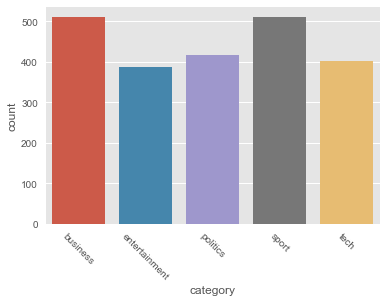

In [12]:
sns.countplot(x='category', data=articles)
 
# Rotate x-labels
plt.xticks(rotation=-45)
plt.show()

This looks like a good spread of article categories.

### Data preparation

In order to make the best NLP model possible that can be generalised to work with unseen data, we incorporate a train-test split. The ratio can be specified if desired but we will use the defaults here, being a 25% test set.

In [13]:
# define X and y
X = articles.article
y = articles.category

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [14]:
print len(X_train)
print len(X_test)

1668
557


### Data Transformation

#### Count Vectorizer
At its essence, a text document is unstructured data. We need a way to go from unstructured data to a numeric X matrix in order to use it with our models. One way to do this is to use a Count Vectorizer. This is a simple tool that creates features using each unique word in the corpi, counts all of the individual words in the document, and assigns this value count to the relevant column in the matrix.

#### TF-IDF Vectorizer

TF-IDF works in a similar way to the Count Vectorizer, but it aims to penalise words that are used frequently, and to raise the significance of words that are used rarely within documents but still may have importance on predicting the correct class.

We will investigate both transformations in our modelling. some example code is shown below, to be able to also show some of the features that are created using the vectorizer.

In [15]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [16]:
# rows are documents, columns are terms (aka "tokens" or "features")
X_train_dtm.shape

(1668, 26264)

In [436]:
# words occuring
words = vect.get_feature_names()
print words[3000:3020]
print


[u'bankrupt', u'bankruptcy', u'banks', u'banned', u'banner', u'banning', u'bannister', u'banos', u'banque', u'banques', u'banquet', u'bans', u'banter', u'banton', u'baoshan', u'bar', u'barbados', u'barbara', u'barbarians', u'barbaric']



We still have the same number of rows but the vectorization has converted every word, or what is believed to be a word, from our test data into a feature. This is like dummy coded variables for words except that we have counts rather than just occurances.

### Machine Learning - Model Selection

For this exercise, I have chosen to evaluate 3 different types of classification algorithms, Logistic Regression, Random Forest, and Naive Bayes. The reason for choosing these three is because they operate in fundamentally different ways to approach the same task.

#### Logistic Regression
Logistic regression is actually a classification algorithm rather than a regression technique like Linear Regression. The procedure aims to maximise the likelihood of the predicted probabilities give the correct class in a log-odds fashion. This model assumes that all features are required and independant from each other, as well as the associated error term. 

#### Naive Bayes
Naive Bayes is a classifier that works on the basis of conditional probability, being that each feature is conditionally independent of every other feature being examined for that category.

#### Random Forest
Random Forest Classifier works using the principle of fitting multiple decision trees on samples of the dataset, which are then averaged to provide a generalised estimator that is not overfitted, which is a common problem with standard decision trees. 

#### Baseline Accuracy
before building a model, it is important to assess the model relative to a baseline accuracy. For the purposes of multiclass classification algorithms, it is the sum of the majority class expressed as a percentage of all classes. As a reminder, here is a summary of the categories and their frequencies.

In [17]:
articles.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

Sport has the largest number of documents, this becomes the baseline accuracy:

In [18]:
511. / len(articles)

0.22966292134831462

#### Basic Modelling
To test the performance with default parameters, I train a logistic regression model on the training set, then use this model to predict the category on the test set. 

In [19]:
# create instance of the model
lr = LogisticRegression()
#fit the model to the training set
lr.fit(X_train_dtm, y_train)
#predict the classes on the test set
y_pred_class = lr.predict(X_test_dtm)

# calculate accuracy by comparing the predicted classes against the true classes
print metrics.accuracy_score(y_test, y_pred_class)

0.97486535009


As we can see, the model performs very well, as we have an accuracy score that is roughly 0.74 better than the baseline accuracy. However, there is a possiblity that there are other models that can perform better. 

#### Automated model asessment
In order to speed up the process, below I write a function that takes a vectorizer and performs 3 different model fits, and calculates their relevant accuracies. This way, we can see demonstrate the importance of appropriate transformation of the data in relation to the performance of the respective models.

In [20]:

def vect_test(vect):
    # transform the unstructured data using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    # print the number of features generated as a result of the transformation
    print 'Features: ', X_train_dtm.shape[1]

    # train Logistic Regression model and measure accuracy
    lr = LogisticRegression()
    lr.fit(X_train_dtm, y_train)
    y_pred_class_lr = lr.predict(X_test_dtm)
    print 'Logistic Regression Accuracy: ', metrics.accuracy_score(y_test, y_pred_class_lr)

    # train Naive Bayes model and measure accuracy
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class_nb = nb.predict(X_test_dtm)
    print 'Naive Bayes Accuracy: ', metrics.accuracy_score(y_test, y_pred_class_nb)
    
    # train Random Forest model and measure accuracy
    rf = RandomForestClassifier()
    rf.fit(X_train_dtm, y_train)
    y_pred_class_rf = rf.predict(X_test_dtm)
    print 'Random Forest Accuracy: ', metrics.accuracy_score(y_test, y_pred_class_rf)



The vectorizers with default parameters are trained below on three types of model. It is noticed that all three models with default parameters perform better than the baseline, with Naive Bayes performing even better than Logistic Regression. It is also noted that TF-IDF improves the Random Forest accuracy a little, but reduces the Naive Bayes accuracy quite a bit.

In [21]:
#standard Count Vectorizer
vect = CountVectorizer()
vect_test(vect)

Features:  26264
Logistic Regression Accuracy:  0.97486535009
Naive Bayes Accuracy:  0.978456014363
Random Forest Accuracy:  0.849192100539


In [22]:
#standard TF-IDF vectorizer
vect = TfidfVectorizer()
vect_test(vect)

Features:  26264
Logistic Regression Accuracy:  0.97486535009
Naive Bayes Accuracy:  0.933572710952
Random Forest Accuracy:  0.867145421903


#### Stop words
Removing stop words improves the accuracy across the board, for both vectorizers, but count vectorizer still performs better than TF-IDF. Note that Logistic Regression performs as well as Naive Bayes using the count vectorizer.

In [23]:
# remove English stop words
vect = CountVectorizer(stop_words='english')
vect_test(vect)

Features:  25971
Logistic Regression Accuracy:  0.980251346499
Naive Bayes Accuracy:  0.980251346499
Random Forest Accuracy:  0.899461400359


In [24]:
#standard TF-IDF vectorizer
vect = TfidfVectorizer(stop_words='english')
vect_test(vect)

Features:  25971
Logistic Regression Accuracy:  0.980251346499
Naive Bayes Accuracy:  0.96947935368
Random Forest Accuracy:  0.917414721724


#### N-grams
Including bigrams can potentially improve the accuracy of the model. For example, single words that might not seem related to a class can suddenly become so when associated with another word. For example, 'American' might not relate to a particular class, but 'American Football' could relate to the sport class. In this dataset however, this seems to have reduced the accuracy of our models.

In [25]:
# include 1-grams and 2-grams
vect = CountVectorizer(stop_words='english', ngram_range=(1, 2))
vect_test(vect)

Features:  281098
Logistic Regression Accuracy:  0.980251346499
Naive Bayes Accuracy:  0.97486535009
Random Forest Accuracy:  0.879712746858


#### Low term frequency filtering
Finally, we try to apply low term frequency as per the original processed dataset. Overall, it appears that it actually degrades the naive bayes model performance.

In [26]:
# remove stop words, and only include terms that appear at least 3 times
vect = CountVectorizer(min_df=3, stop_words='english')
vect_test(vect)

Features:  11138
Logistic Regression Accuracy:  0.980251346499
Naive Bayes Accuracy:  0.976660682226
Random Forest Accuracy:  0.910233393178


### Gridsearch
Now that we have our best data preparation, we now need to obtain the best hyperparameters for the best model. Naive Bayes typically does not have hyperparameters, but Logistic Regression does. We aim to see if we can improve the model by reducing unnecessary features using regularisation techniques and invoke 10 fold cross-validation to reduce overfitting. L1, also known as Lasso, is a technique that limits the the absolute size of the coefficients. It is also possible that some coefficients can become zero during this exercise, with features effectively eliminated. L2, also known as Ridge, adds a penalty equal to the square of the magnitude of the coefficients. As a result, all features are affected,  but not eliminated. It is possible to have a feature that is very small coefficent but will not be zero.

The C value, is a float that indicates the amount of regularization used. A small number indicates strong regularisation, and a large number the inverse. Here I specify a range of 10^-4 to 10^4 to evaluate, which is a reasonably large range.

In [27]:
#transform the data
vect = CountVectorizer(stop_words='english')
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

#instansiate the model
model = LogisticRegression() 

#provide parameters for the gridsearch
params = {'penalty': ['l1','l2'],
          'C': np.logspace(-4, 4, 10)}

#perform gridsearch with 10 fold cross validation and print best estimator and score
estimator = GridSearchCV(model,param_grid=params,cv=10, n_jobs=-1, verbose=1)
estimator.fit(X_train_dtm,y_train)
print estimator.best_estimator_
print estimator.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.6s finished


LogisticRegression(C=0.046415888336127774, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.975419664269


In [28]:
lrpredictions = estimator.best_estimator_.predict(X_test_dtm)
print metrics.accuracy_score(y_test, lrpredictions)

0.982046678636


### Results
As we can see from above, gridsearch adopted L2 (Ridge) as the better regularization technique, and the C value is small, which indicates that a large amount of regularization was used. The accuracy score on the training set was lower than our predicted accuracy score in the vectorizer evaluation, but we actually performed marginally better on the unseen test data. This shows that our model generalises well, and marginally outperforms the Naive Bayes Classifier.

It is important to note that although we have a good model, with a high accuracy score, it is important to evaluate how many documents the model actually classified correctly. For this, we use a confusion matrix to visualise this. The below function plots this matrix in a pretty way.

In [29]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, xlab='Predicted magnitude',\
                         ylab='True magnitude'):
    sns.set(font_scale=0.8)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.show()

As a reminder, we show the number of documents in our test set. We have 557 documents. The diagonal of the matrix shows those articles that have been predicted correctly. As we can see, we have prediced the classes of 547 articles out of the test set correctly, with just 10 articles mis-classified.

In [30]:
len(y_test)

557

In [31]:
confmat = metrics.confusion_matrix(y_test,lrpredictions)

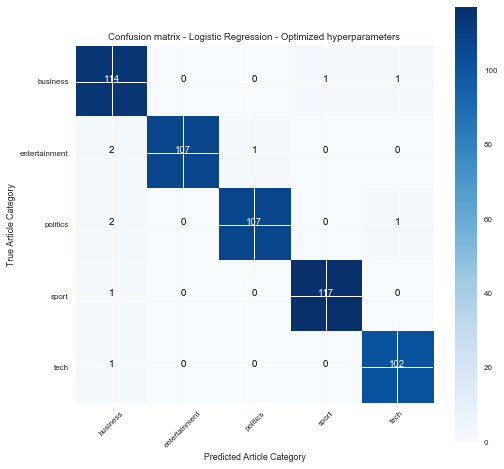

In [32]:
plot_confusion_matrix(confmat, estimator.best_estimator_.classes_,
                      'Confusion matrix - Logistic Regression - Optimized hyperparameters',
                      xlab='Predicted Article Category', ylab='True Article Category')
plt.show()


### Conclusion
Through exploration of the dataset and various modelling techniques, I have demonstrated the importance of feature engineering in evaluating model performance and accuracy. The original pre-prepared dataset as provided on the website included stemming, stop word removal and low term frequency filtering. By ingesting the original documents and evaluating some of these procedures it is noted that low term frequency filtering did not improve the accuracy of our model, but stop word removal was significant. The type of vectorizer used to transform the unstructured text was also important in the ultimate model selection. Finally, optimizing our best model using gridsearch gave us a 98% accuracy in classifying news articles correctly using Logistic Regression.

To extend this work, we could go further in the accuracy analysis by plotting the Precision-Recall and ROC curves for each of the classes. Furthermore, we could have explored the effects of stemming and lemmatization on the accuracy, as well as analysing sentences instead of individual words to gain a better understanding of the document as a whole.